## Pre Processing;
1. Pre process file to trim start and end '"'
2. Impute missing column Description and Customer_ID
3. AmountSpent = Unit Price*Total Units

## Segmentation modeling
1. Customer segmentation with total units price and number of units purchased with K-means
2. Using RMF Analysis
3. doc2vec with product description & doc2vec with product description & country
4. Use Fast text or Bert for embed product description

In [1]:
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
glob.glob('data/ML*.txt')

['data\\ML Data Sample.txt', 'data\\ML Data.txt', 'data\\ML Data_new.txt']

In [7]:
source_file = 'data\\ML Data.txt'
PATTERN = re.compile(r'''((?:[^,"]|"[^"]*"|'[^']*')+|(?=,,)|(?=,$)|(?=^,))''')

df = pd.read_csv(source_file, encoding='latin1')
cols = PATTERN.split(df.columns[0])[1::2]

df[cols] = pd.DataFrame(df.iloc[:,0].apply(lambda x: PATTERN.split(x)[1::2]).tolist(), index= df.index)
df.Invoice_Date = pd.to_datetime(df.Invoice_Date)
print(df.shape)
print(df.columns)
display(df.head())

(541909, 9)
Index(['Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country',
       'Invoice_Number', 'Product_Code', 'Description', 'Quantity',
       'Invoice_Date', 'Unit_Price', 'Customer_ID', 'Country'],
      dtype='object')


,"Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country",Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country
0,"536365,85123A,WHITE HANGING HEART T-LIGHT HOLD...",536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,"536365,71053,WHITE METAL LANTERN,6,12-01-2010 ...",536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,"536365,84406B,CREAM CUPID HEARTS COAT HANGER,8...",536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,"536365,84029G,KNITTED UNION FLAG HOT WATER BOT...",536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,"536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6...",536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [42]:
df.dtypes

Invoice_Number            string
Product_Code              string
Description               string
Quantity                   int32
Invoice_Date      datetime64[ns]
Unit_Price               float64
Customer_ID               string
Country                   string
dtype: object

In [43]:
df.describe(exclude=[np.number])

,Invoice_Number,Product_Code,Description,Invoice_Date,Customer_ID,Country
count,541909,541909,540455,541909,406829,541909
unique,25900,4070,4223,23260,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,17841,United Kingdom
freq,1114,2313,2369,1114,7983,495478
first,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN
last,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN


### Check for duplicate & remove

In [44]:
df.drop_duplicates(inplace=True)
print(df.shape)

(536641, 8)


### Check for occurance of None

In [45]:
df.isna().sum()

Invoice_Number         0
Product_Code           0
Description         1454
Quantity               0
Invoice_Date           0
Unit_Price             0
Customer_ID       135037
Country                0
dtype: int64

### Univariate analysis of product quantity
1. Number of transaction vs cancellation
2. Number of transaction vs cancellation per country
3. Remove cancellation transaction

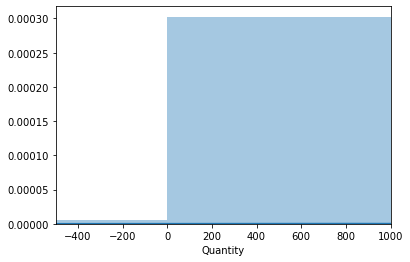

In [46]:
sns.distplot(df.Quantity)
plt.xlim(-500, 1000)
plt.show()

In [47]:
df['Cancellation'] = df.Quantity<0
df.loc[df.Cancellation==True].head()

,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True


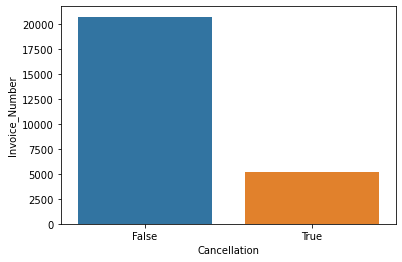

In [48]:
temp_df = df.groupby([df.Cancellation])['Invoice_Number'].nunique().reset_index()
sns.barplot(x='Cancellation',y='Invoice_Number', data=temp_df)

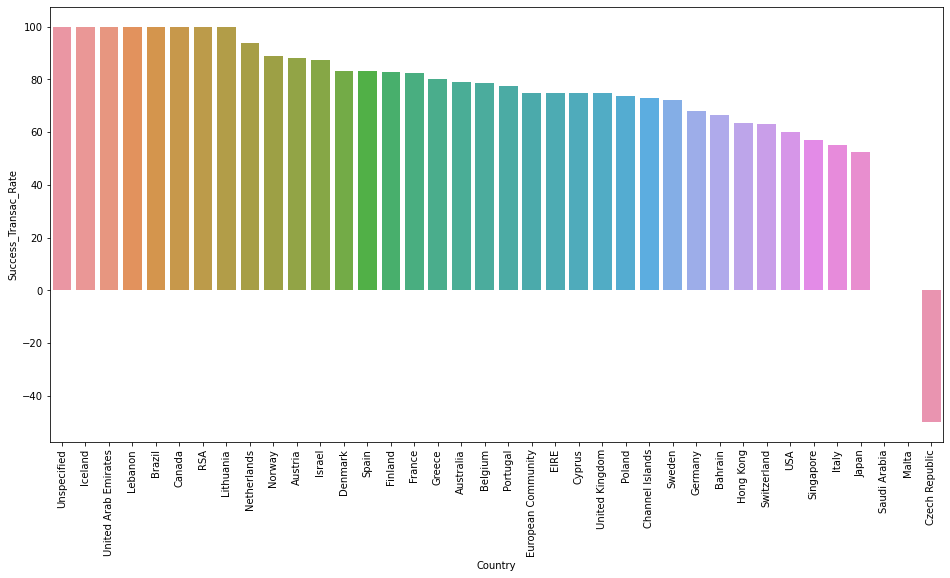

In [49]:
temp_df = df.groupby([df.Cancellation, df.Country])['Invoice_Number'].nunique().reset_index()

temp_df = temp_df.pivot(index='Country', columns='Cancellation', values='Invoice_Number')
temp_df.columns = temp_df.columns.map(lambda x: f'Cancellation_{x}')
temp_df = temp_df.reset_index()
temp_df = temp_df.fillna(0)
temp_df['Success_Transac_Rate'] = ((temp_df.Cancellation_False-temp_df.Cancellation_True)/temp_df.Cancellation_False)*100
plt.figure(figsize=(16, 8))
sns.barplot(x='Country',y='Success_Transac_Rate', data=temp_df, order=temp_df.sort_values('Success_Transac_Rate', ascending=False).Country)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [50]:
print(df.loc[df.Cancellation==True].shape)
df.loc[df.Cancellation==True].head()

(10587, 9)


,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True


In [51]:
df = df.loc[df.Cancellation==False]
print(df.shape)

(526054, 9)


In [52]:
print(df.loc[df.Cancellation==True].shape)
df.loc[df.Cancellation==True].head()

(0, 9)


,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation


### Univariate analysis Unit_Price
1. Filter rows with negative units price as it does not convey right purchase order

In [53]:
df.Unit_Price.describe()

count    526054.000000
mean          3.871747
std          42.016560
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: Unit_Price, dtype: float64

In [54]:
df =df.loc[df.Unit_Price>0]
print(df.shape)

(524878, 9)


### Imputing missing product description: 
1. With multi product description replace product description with the most the occurrence description
2. Impute missing description for remaining blank product description

In [55]:
df.Description.isna().sum()

0

In [56]:
df.groupby(['Product_Code'])['Description'].nunique().sort_values(ascending=False)

Product_Code
23236     4
23196     4
17107D    3
22776     3
23366     3
         ..
46776B    1
46776A    1
46775D    1
46138B    1
10002     1
Name: Description, Length: 3922, dtype: int64

In [57]:
product_desc_mapping_df = pd.DataFrame(df.groupby(['Product_Code', 'Description'])['Invoice_Number'].nunique().reset_index()).sort_values(['Product_Code', 'Invoice_Number'], ascending=False).groupby('Product_Code').head(1).drop('Invoice_Number', axis=1)
product_desc_mapping_df.head()

,Product_Code,Description
4160,m,Manual
4159,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00
4158,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00
4157,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00
4156,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00


In [58]:
df = pd.merge(df.drop('Description', axis=1), product_desc_mapping_df, how='outer')
df.loc[df.Description.isna(), 'Description'] = 'missing_description'

In [59]:
df.Description.isna().sum()

0

In [60]:
df.groupby(['Product_Code'])['Description'].nunique().sort_values(ascending=False)

Product_Code
m         1
22429     1
22427     1
22426     1
22425     1
         ..
44228     1
44092C    1
44092B    1
44091A    1
10002     1
Name: Description, Length: 3922, dtype: int64

## Imputing missing Customer_ID:
1. Checks to find if missing Customer_ID can be found with any matching invoice number.
2. Check if any particular country exhibits missing Customer_ID.
3. Impute missing customer id as unique customer as per their available transaction id

In [61]:
df.loc[df.Invoice_Number.isin(df.loc[df.Customer_ID.isna(), 'Invoice_Number'].unique())].Customer_ID.unique()

<StringArray>
[<NA>]
Length: 1, dtype: string

In [62]:
df.Country.value_counts()/len(df)

United Kingdom          0.914470
Germany                 0.017194
France                  0.015988
EIRE                    0.015011
Spain                   0.004723
Netherlands             0.004494
Belgium                 0.003869
Switzerland             0.003730
Portugal                0.002843
Australia               0.002250
Norway                  0.002040
Italy                   0.001444
Channel Islands         0.001423
Finland                 0.001305
Cyprus                  0.001149
Sweden                  0.000857
Unspecified             0.000842
Austria                 0.000758
Denmark                 0.000724
Poland                  0.000629
Japan                   0.000612
Israel                  0.000556
Hong Kong               0.000533
Singapore               0.000423
Iceland                 0.000347
USA                     0.000341
Canada                  0.000288
Greece                  0.000276
Malta                   0.000213
United Arab Emirates    0.000130
European C

In [63]:
df.loc[df.Customer_ID.isna(), 'Country'].value_counts()/len(df.Customer_ID.isna())

United Kingdom    0.249166
EIRE              0.001244
Hong Kong         0.000533
Unspecified       0.000383
Switzerland       0.000223
France            0.000126
Israel            0.000090
Portugal          0.000074
Bahrain           0.000002
Name: Country, dtype: float64

In [64]:
df.loc[df.Customer_ID.isna() & df.Country.isin(['United Kingdom']), :].iloc[12:16, :]

,Invoice_Number,Product_Code,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation,Description
142,538524,85123A,27,2010-12-13 09:35:00,5.91,<NA>,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
146,538566,85123A,7,2010-12-13 11:21:00,5.91,<NA>,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
199,539434,85123A,4,2010-12-17 14:41:00,5.91,<NA>,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
200,539436,85123A,9,2010-12-17 14:49:00,5.91,<NA>,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER


In [65]:
df.loc[df.Customer_ID.isna(), 'Customer_ID'] = 'missing_cust_id_'+df.loc[df.Customer_ID.isna(), 'Invoice_Number']
df.iloc[12:16, :]

,Invoice_Number,Product_Code,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation,Description
12,536575,85123A,128,2010-12-01 16:01:00,2.55,13777,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
13,536576,85123A,128,2010-12-01 16:11:00,2.55,13777,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
14,536590,85123A,6,2010-12-01 16:52:00,2.95,13065,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
15,536592,85123A,9,2010-12-01 17:06:00,5.91,missing_cust_id_536592,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER


### Customer segmmentation with total units price and number of units purchased with K-means

In [66]:
df_cluster = df.groupby(['Customer_ID']).agg({'Quantity':sum, 'Unit_Price': sum}).reset_index()
print(df_cluster.shape)
display(df_cluster.head())

(5766, 3)


,Customer_ID,Quantity,Unit_Price
0,12346,74215,1.04
1,12347,2458,481.21
2,12348,2341,178.71
3,12349,631,605.10
4,12350,197,65.30


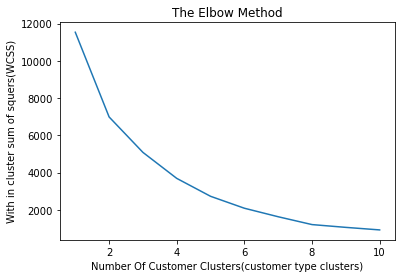

In [67]:
X = df_cluster.loc[:, ['Quantity', 'Unit_Price']].values
X = StandardScaler().fit_transform(X)
with_in_cluster_sum_squares_list = [] 

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    with_in_cluster_sum_squares_list.append(kmeans.inertia_)

sns.lineplot(x=range(1,11), y= with_in_cluster_sum_squares_list)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()

c:\users\srikant panda\appdata\local\programs\python\python37\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


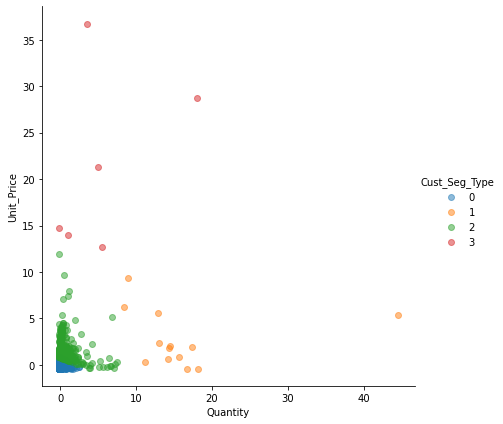

In [69]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++')

df_cluster_pred = pd.DataFrame(X, columns=['Quantity', 'Unit_Price'])
df_cluster_pred.loc[:, 'Cust_Seg_Type'] = kmeans.fit_predict(X)

g = sns.FacetGrid(df_cluster_pred, hue="Cust_Seg_Type",size=6, aspect=1)
g.map(plt.scatter, "Quantity", "Unit_Price", alpha=.5)
g.add_legend()
plt.show()

### Using RMF Analysis

In [73]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [74]:
temp_df = df.copy()
display(temp_df.head())

,Invoice_Number,Product_Code,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation,Description
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
1,536373,85123A,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
2,536375,85123A,6,2010-12-01 09:32:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
3,536390,85123A,64,2010-12-01 10:19:00,2.55,17511,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
4,536394,85123A,32,2010-12-01 10:39:00,2.55,13408,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER


#### Recency

In [97]:
df_recency = pd.DataFrame(temp_df.groupby(['Customer_ID'])['Invoice_Date'].max()).reset_index()
df_recency['Recency'] = (temp_df.Invoice_Date.max()-df_recency['Invoice_Date']).dt.days
df_recency = df_recency.drop('Invoice_Date', axis=1)
df_recency.head()

,Customer_ID,Recency
0,12346,325
1,12347,1
2,12348,74
3,12349,18
4,12350,309


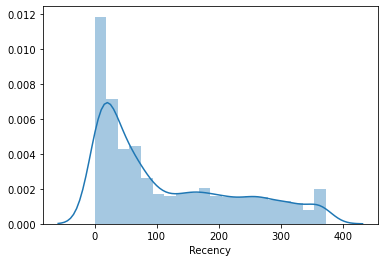

In [98]:
sns.distplot(df_recency.Recency)
plt.show()

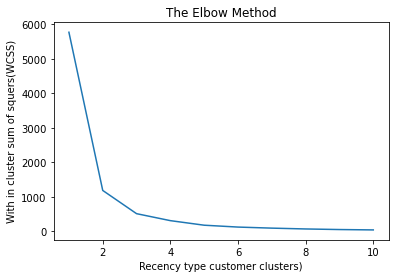

In [99]:
with_in_cluster_sum_squares_list = [] 

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(StandardScaler().fit_transform(df_recency[['Recency']]))
    with_in_cluster_sum_squares_list.append(kmeans.inertia_)

sns.lineplot(x=range(1,11), y= with_in_cluster_sum_squares_list)
plt.title('The Elbow Method')
plt.xlabel('Recency type customer clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()

In [100]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
kmeans.fit(StandardScaler().fit_transform(df_recency[['Recency']]))
df_recency['Recency_Cluster'] = kmeans.predict(StandardScaler().fit_transform(df_recency[['Recency']]))

df_recency = order_cluster('Recency_Cluster', 'Recency', df_recency,False)
print(df_recency.Recency_Cluster.nunique())
df_recency.head()

3


,Customer_ID,Recency,Recency_Cluster
0,12346,325,0
1,12350,309,0
2,12361,286,0
3,12365,290,0
4,12373,310,0


#### Frequency

In [101]:
df_frequency = pd.DataFrame(temp_df.groupby(['Customer_ID'])['Invoice_Number'].nunique()).reset_index().rename({'Invoice_Number':'Frequency'}, axis=1)
df_frequency.head()

,Customer_ID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


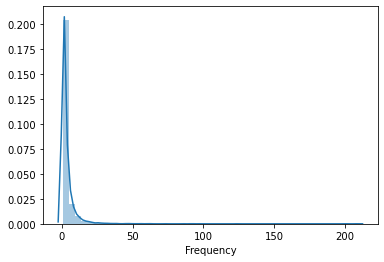

In [102]:
sns.distplot(df_frequency.Frequency)
plt.show()

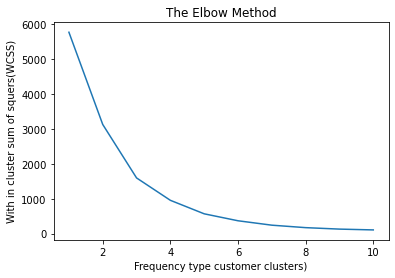

In [103]:
with_in_cluster_sum_squares_list = [] 

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(StandardScaler().fit_transform(df_frequency[['Frequency']]))
    with_in_cluster_sum_squares_list.append(kmeans.inertia_)

sns.lineplot(x=range(1,11), y= with_in_cluster_sum_squares_list)
plt.title('The Elbow Method')
plt.xlabel('Frequency type customer clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()

In [104]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++')
kmeans.fit(StandardScaler().fit_transform(df_frequency[['Frequency']]))
df_frequency['Frequency_Cluster'] = kmeans.predict(StandardScaler().fit_transform(df_frequency[['Frequency']]))

df_frequency = order_cluster('Frequency_Cluster', 'Frequency', df_frequency,False)
print(df_frequency.Frequency_Cluster.nunique())

df_frequency.head()

4


,Customer_ID,Frequency,Frequency_Cluster
0,12346,1,3
1,12347,7,3
2,12348,4,3
3,12349,1,3
4,12350,1,3


#### Revenue

In [105]:
temp_df['Total_Spent'] = temp_df.Quantity*temp_df.Unit_Price
df_revenue = pd.DataFrame(temp_df.groupby(['Customer_ID'])['Total_Spent'].sum()).reset_index().rename({'Total_Spent':'Revenue'}, axis=1)
df_revenue.head()

,Customer_ID,Revenue
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


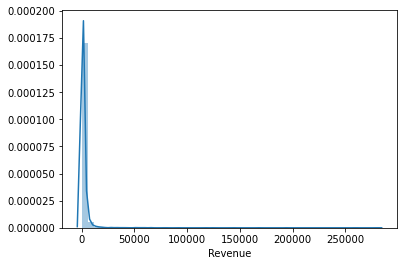

In [106]:
sns.distplot(df_revenue.Revenue)
plt.show()

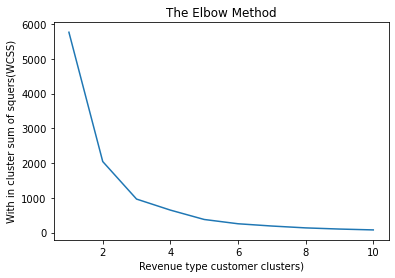

In [107]:
with_in_cluster_sum_squares_list = [] 

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(StandardScaler().fit_transform(df_revenue[['Revenue']]))
    with_in_cluster_sum_squares_list.append(kmeans.inertia_)

sns.lineplot(x=range(1,11), y= with_in_cluster_sum_squares_list)
plt.title('The Elbow Method')
plt.xlabel('Revenue type customer clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()

In [108]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
kmeans.fit(StandardScaler().fit_transform(df_revenue[['Revenue']]))
df_revenue['Revenue_Cluster'] = kmeans.predict(StandardScaler().fit_transform(df_revenue[['Revenue']]))

df_revenue = order_cluster('Revenue_Cluster', 'Revenue', df_revenue,False)
print(df_revenue.Revenue_Cluster.nunique())

df_revenue.head()

3


,Customer_ID,Revenue,Revenue_Cluster
0,12346,77183.60,1
1,12415,124914.53,1
2,12748,33053.19,1
3,12931,42055.96,1
4,13081,28337.38,1


In [109]:
df_rfm = pd.DataFrame()
for i in [df_recency, df_frequency, df_revenue]:
    if df_rfm.shape[0]==0:
        df_rfm = i
    else:
        df_rfm = pd.merge(df_rfm, i, on='Customer_ID')
        
df_rfm.head()

,Customer_ID,Recency,Recency_Cluster,Frequency,Frequency_Cluster,Revenue,Revenue_Cluster
0,12346,325,0,1,3,77183.60,1
1,12350,309,0,1,3,334.40,2
2,12361,286,0,1,3,189.90,2
3,12365,290,0,2,3,641.38,2
4,12373,310,0,1,3,364.60,2


In [110]:
df_rfm['Overall_Score'] = df_rfm['Recency_Cluster'] + df_rfm['Frequency_Cluster'] + df_rfm['Revenue_Cluster']
df_rfm.groupby('Overall_Score')['Recency','Frequency','Revenue'].mean()

c:\users\srikant panda\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Recency,Frequency,Revenue
Overall_Score,,,
2,0.000000,201.000000,143711.170000
3,63.333333,91.000000,135536.391667
4,65.611111,44.166667,52235.445556
5,290.966415,2.215785,1642.458035
6,123.943375,4.652322,1945.309276
7,37.641164,2.716595,1204.511337


In [115]:
df_rfm.loc[:,'Segment'] = 'High-Value'
df_rfm.loc[df_rfm['Overall_Score']==4,'Segment'] = 'Mid-Value' 
df_rfm.loc[df_rfm['Overall_Score']>4,'Segment'] = 'Low-Value' 

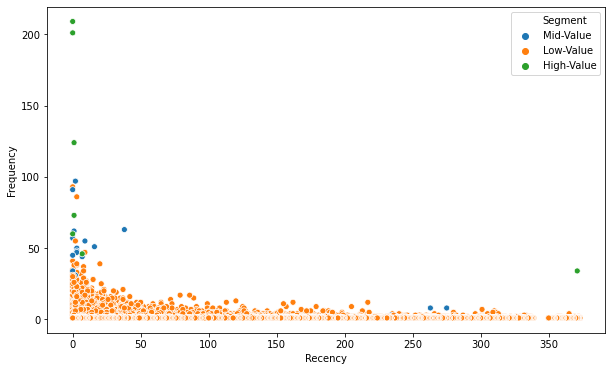

In [116]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Recency',y='Frequency',data=df_rfm,hue='Segment')
plt.show()

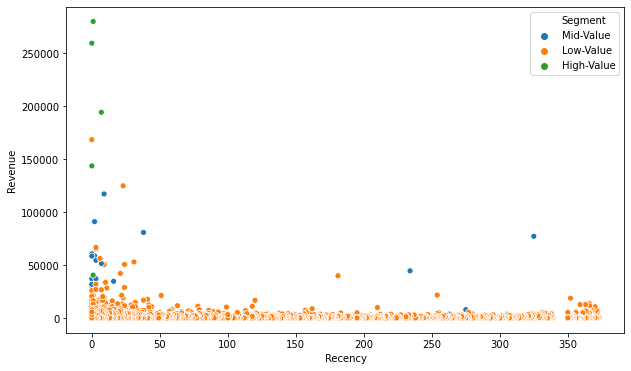

In [119]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Recency',y='Revenue',data=df_rfm,hue='Segment')
plt.show()

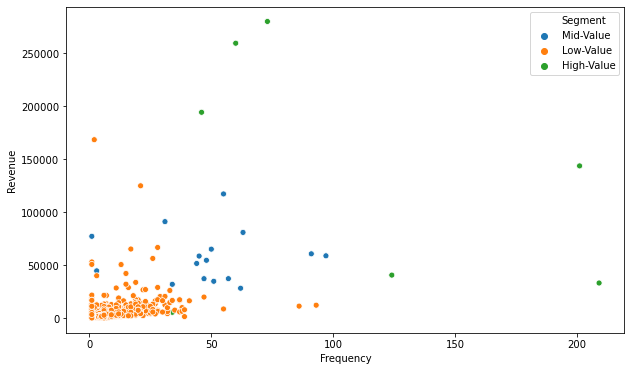

In [118]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Frequency',y='Revenue',data=df_rfm,hue='Segment')
plt.show()